# 学習に関するテクニック

## 6.1 パラメータの更新

- ニューラルネットワークの学習は、「損失関数」を出来るだけ小さくするような最適なパラメータを見つける問題である。
- このように、最適なパラメータを見つける問題を解くことを**最適化**という
- パラメータ空間はとても複雑であり、最適な解をみつけることは難しい

### SGD法
確率的勾配降下法。パラメータの勾配を使って、勾配方向にパラメータを更新するというステップを繰り返す。
- 勾配という局所的な情報のみを用いて最適化問題を解く。
- 冒険家に例えると、地図をみないで目隠しをしながら進んでいる。傾きが一番深い方向に進んでいく。

定式化すると、以下のように書ける

$$
{\bf W} \leftarrow {\bf W} - \eta\frac{\partial L}{\partial {\bf W}}
$$

- 更新する重みパラメータを$\bf W$、$\bf W$に関する損失関数の勾配を$\frac{\partial L}{\partial \bf W}$とする。
- $\eta$は学習係数を表す。0.01や0.001などの値を事前に決めておく

以下のように、SGD法をクラスとして実行する。


In [91]:
class SGD:
    def __init__(self, lr=0.01): # lr とは、learning rate(学習係数)のこと
        self.lr = lr
    
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

疑似コードだが、以下のようにして用いる。

```
network = TwoLayerNet(...)
optimizer = SGD()

for i in range(10000):
    ...
    x_batch , t_batch = get_mini_batch(...)#ミニバッチ
    grads = network.gradient(x_batch, t_batch)
    params = network.params
    optimizer.update(params, grads)
    ...
```

変数optimizerは、「最適化を行う関数」であり、モジュール化されている。付け替えることもできる。

### 6.1.3 SGD の欠点
- 問題によっては非効率な可能性がある。
$$
f(x,y) = \frac{1}{20} x^2 + y^2
$$
のような関数は、y軸方法の傾斜は大きいがx軸方向の傾斜がとても小さい

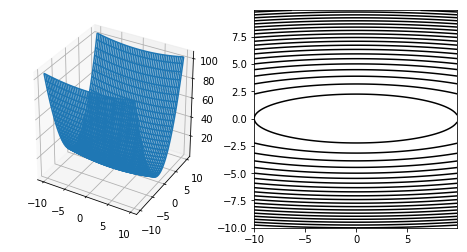

In [92]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

def func1(x,y):
    return x**2/20 + y**2

x = np.arange(-10.0,10.0,0.1)
y = np.arange(-10.0,10.0,0.1)
X, Y = np.meshgrid(x,y)

fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1,2,1,projection='3d')
ax.plot_wireframe(X, Y, Z)
ax2 = fig.add_subplot(1,2,2)
plt.contour(X,Y,Z,20,colors=['black'])

plt.show()

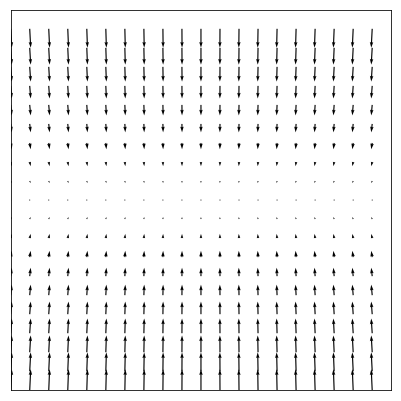

In [93]:
x = np.arange(-10.0,10.0,1.0)
y = np.arange(-10.0,10.0,1.0)
X, Y = np.meshgrid(x,y)

u,v = -X/10 , -2*Y
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1)
ax.quiver(X,Y,u,v)
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
ax.axis([-10.0, 10.0, -10.0, 10.0])
ax.set_aspect('equal')

plt.show()

In [141]:
optimizer = SGD(lr=0.9)

params = {"x":-7.0,"y":2.0}
params_log = []

for i in range(20):
    grads = {"x":params["x"]/10, "y":params["y"]*2}
    if i % 1 == 0:
        print(params)
    optimizer.update(params, grads)
    params_log.append(params)
    
    # 答えは(x,y)=(0,0)


{'x': -7.0, 'y': 2.0}
{'x': -6.37, 'y': -1.6}
{'x': -5.7967, 'y': 1.2800000000000002}
{'x': -5.274997000000001, 'y': -1.0240000000000005}
{'x': -4.800247270000001, 'y': 0.8192000000000004}
{'x': -4.3682250157, 'y': -0.6553600000000004}
{'x': -3.975084764287, 'y': 0.5242880000000003}
{'x': -3.6173271355011702, 'y': -0.4194304000000003}
{'x': -3.291767693306065, 'y': 0.33554432000000023}
{'x': -2.9955086009085194, 'y': -0.2684354560000002}
{'x': -2.7259128268267525, 'y': 0.21474836480000015}
{'x': -2.4805806724123447, 'y': -0.17179869184000013}
{'x': -2.2573284118952337, 'y': 0.13743895347200014}
{'x': -2.054168854824663, 'y': -0.10995116277760011}
{'x': -1.869293657890443, 'y': 0.0879609302220801}
{'x': -1.7010572286803032, 'y': -0.07036874417766409}
{'x': -1.547962078099076, 'y': 0.05629499534213128}
{'x': -1.4086454910701591, 'y': -0.045035996273705026}
{'x': -1.2818673968738448, 'y': 0.036028797018964026}
{'x': -1.1664993311551988, 'y': -0.02882303761517123}


このように、関数が等方的ではない場合には、学習がジグザグに進んで非効率(本書図6-3)

これを解決する手法として、Momentum, Adagrad, Adamの3つを紹介する。

### 6.1.4 Momentum
モーメンタム(Momentum)とは、「運動量」という意味の言葉である。物理に関係があり、Momentumという手法は数式で次のように表される。
$$
{\bf v} \leftarrow \alpha {\bf v} -\eta\frac{\partial L}{\partial\bf W}\\
{\bf W} \leftarrow {\bf W} +{\bf v}
$$

あらたに登場したvは、物理でいうところの速度に対応する。　上の式は、物体が勾配方向に力を受け、その力によって物体の速度が加算されるという物理法則を表している(運動方程式)

$\alpha\bf v$という項は物体が何も力を受けない時に徐々に減速する役割を担う。空気抵抗のようなイメージ。通常$\alpha$には1未満の値を設定する(0.9など。これが1以上だと振動してしまう。)

In [142]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    def update(self, params, grads):
        if self.v is None:
            self.v={}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val) # vの初期値は0
        
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

optimizer = Momentum(lr=0.9)
params = {"x":-7.0,"y":2.0}
params_log = []

for i in range(20):
    grads = {"x":params["x"]/10, "y":params["y"]*2}
    if i % 1 == 0:
        print(params)
    optimizer.update(params, grads)
    params_log.append(params)
    
    # 答えは(x,y)=(0,0)


{'x': -7.0, 'y': 2.0}
{'x': -6.37, 'y': -1.6}
{'x': -5.2297, 'y': -1.96}
{'x': -3.7327570000000003, 'y': 1.2440000000000002}
{'x': -2.0495601700000003, 'y': 1.8884000000000003}
{'x': -0.35022260770000013, 'y': -0.9307600000000003}
{'x': 1.210701233063, 'y': -1.7926360000000006}
{'x': 2.5065695787740303, 'y': 0.6584204}
{'x': 3.4472598278242947, 'y': 1.6792144400000006}
{'x': 3.9836276674653464, 'y': -0.4246569159999998}
{'x': 4.107832233070411, 'y': -1.5537586876000005}
{'x': 3.849911441138633, 'y': 0.22681535563999988}
{'x': 3.2712906986975554, 'y': 1.4210643544040005}
{'x': 2.4561158676178056, 'y': -0.06202738463559987}
{'x': 1.5014080915604282, 'y': -1.2851606574271606}
{'x': 0.5070443648683499, 'y': -0.07269141957067604}
{'x': -0.4335169819926721, 'y': 1.149375449727377}
{'x': -1.2410056657882516, 'y': 0.18035982258634609}
{'x': -1.8560549712833303, 'y': -1.0164019224960046}
{'x': -2.2425543988134016, 'y': -0.2639640325773118}


これを用いた学習では、ジグザグが軽減される。(本書図6-5)
- y軸方向は正と負の力を交互に受けるため、それらが打ち消し合う。
- x軸方向へ受ける力は小さいが、常に同じ方向の力を受けるため、加速していく、

### 6.1.5 AdaGrad(アダグラッド)
ニューラルネットワークの学習では、学習係数$\eta$の決定が非常に重要である(第4章でも述べた)
- 小さすぎると学習に時間がかかり過ぎてしまう
- 大きすぎると発散して正しい学習が行えない

学習係数に関するテクニックとして、**学習係数を減衰**させる方法がある。</br>
最初に「大きく」学習し、次第に「小さく」学習させるという手法を用いる。
上記は、パラメータ「全体」の学習係数を一括して下げているが、それをさらに発展させて、AdaGradは一つ一つのパラメータに対して学習係数を別々に減衰させる。

$$
h \leftarrow h + \frac{\partial L}{\partial \bf W}\cdot \frac{\partial L}{\partial \bf W}\\
{\bf W} \leftarrow {\bf W} - \eta \frac{1}{\sqrt{h}} \frac{\partial L}{\partial \bf W}
$$

$\frac{\partial L}{\partial \bf W}\cdot \frac{\partial L}{\partial \bf W}$は、同じ要素ごとに掛け算している(各要素を2乗する)

これは、パラメータが学習でよりよく動いた（大きく更新された）ら、学習係数が強く減衰することに相当する。

AdaGradは無限に学習を行うと更新量は0になり、全く更新されなくなってしまう。その問題を改善した手法としてRMSPropという方法がある。
- 古い勾配は指数関数的に減衰させて忘れていく
- 新しいパラメータの移動が、学習係数に強く反映される。


In [143]:
class AdaGrad:
    def __init__(self, lr=0.01): #lr が学習係数
        self.lr = lr
        self.h = None
    def update(self, params, grads):
        if self.h is None:
            self.h={}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val) # hの初期値は0
        
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] /(np.sqrt(self.h[key]) + 1e-7)

In [145]:
optimizer = AdaGrad(lr=0.9)
params = {"x":-7.0,"y":2.0}
params_log = []

for i in range(100):
    grads = {"x":params["x"]/10, "y":params["y"]*2}
    if i % 10 == 0:
        print(params)
    optimizer.update(params, grads)
    params_log.append(params)
    
    # 答えは(x,y)=(0,0)


{'x': -7.0, 'y': 2.0}
{'x': -3.1505018890210024, 'y': 0.016275436488859776}
{'x': -1.8063710973365936, 'y': 0.0001619246993519505}
{'x': -1.0720749933018099, 'y': 1.6110157032872744e-06}
{'x': -0.6429692021915013, 'y': 1.602826258319096e-08}
{'x': -0.3870032442372609, 'y': 1.5946784436150485e-10}
{'x': -0.23323552710041623, 'y': 1.5865720475514227e-12}
{'x': -0.14062917546300768, 'y': 1.5785068595805033e-14}
{'x': -0.0848064605264873, 'y': 1.570482670224873e-16}
{'x': -0.051145672462547094, 'y': 1.5624992710719739e-18}


AdaGradでは、最小値に向かって効率的に動いている(本書図6-6)

### 6.1.6 Adam
Adamは、Momentum(ボールが転がるような動き)とAdaGrad(学習係数をパラメータごとに減衰させる)を融合したような手法である。

### 6.1.7　どの更新手法を用いるか？
(図6-8) 
それぞれ得意不得意がある。
多くの研究では今でもSGDが使われている。最近では、Adamが好んで使われている。

<img src="fig6-8.png" alt="drawing" width="600"/>

(本書　図6-9)一般的にSGDは遅い